In [ ]:
# Importations
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Reshape, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

import seaborn as sns

In [2]:
class Graphes:

    @staticmethod
    def accuracy_loss_graphe(historique):
        # Affichage accuracy - loss
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
        axs = axs.flatten()
        axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
        axs[0].plot(historique.history["val_accuracy"], label='Accuracy Val')
        axs[0].set_title(f"Evolution de l'accuracy")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()

        axs[1].plot(historique.history["loss"], label='Loss Train')
        axs[1].plot(historique.history["val_loss"], label='Loss Val')
        axs[1].set_title(f"Evolution de la perte")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.show()

In [ ]:
# Fonction de création d'une image 'imparfaite' via une ancienne image - style 2

def create_imperfect_image(image, image_size=(56, 56), seed=1):
    random.seed(seed)
    new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

    max_offset = image_size[0] - image.shape[0]
    random_x = random.randint(0, max_offset)
    random_y = random.randint(0, max_offset)

    new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
    return new_image

In [ ]:
# Fonction de création de nouvelles images via d'anciennes - style 1

def generation_propre(X, y, nb=10000, seed=1):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
    )

    new_images_generator = datagen.flow(X, batch_size=1, shuffle=False, seed=seed)

    X_new = X.tolist()
    y_new = y.tolist()
    for i in range(nb):
        img = next(new_images_generator)[0]
        X_new.append(img.tolist())
        y_new.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(img, cmap="grey")
          plt.axis("off")
          plt.show()
    return np.array(X_new), np.array(y_new)


In [ ]:
# Fonction de création de nouvelles images via d'anciennes - style 2


def generation_imparfaite(X, y, nb=10000, seed=1):
    new_images = X.tolist()
    new_images_label = y.tolist()

    for i in range(nb):
        imperfect_image = create_imperfect_image(X[i], seed=i+seed)

        # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
        imperfect_image = tf.expand_dims(imperfect_image, axis=0)
        imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

        imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


        new_images.append(imperfect_image.tolist())
        new_images_label.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(imperfect_image, cmap="grey")
          plt.axis("off")
          plt.show()

    new_images = np.array(new_images)
    new_images_label = np.array(new_images_label)

    return new_images, new_images_label

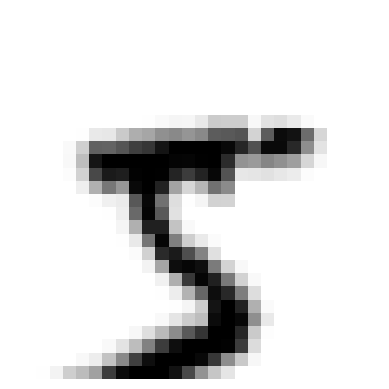

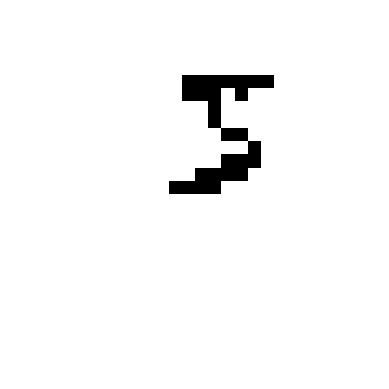

In [ ]:
# Chargement et traitement des données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test

# Génération de nouvelles données imparfaites
x_train, y_train = generation_propre(x_train, y_train, 20000) #  style 1
x_train, y_train = generation_imparfaite(x_train, y_train, 25000) #  style 2

# Mélange (pour validation_split)
np.random.seed(42)
indice = np.random.permutation(len(x_train))
x_train = x_train[indice]
y_train = y_train[indice]

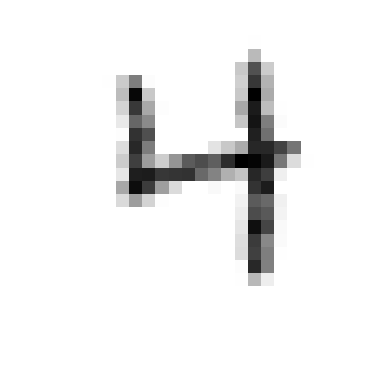

In [ ]:
# Apercu dataset
for i in range(1):
    plt.figure()
    plt.imshow(x_train[i], cmap="grey")
    plt.axis("off")
    plt.show()

In [ ]:
# Optimisation Bayésienne

def build_model(hp):
    model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Reshape((-1, 128)),

      Bidirectional(GRU(hp.Choice('units_1', [128, 256, 512]), activation=hp.Choice('activation', ['tanh', 'relu']), return_sequences=True)),
      Dropout(0.25),

      Bidirectional(GRU(hp.Choice('units_2', [128, 256, 512]), activation=hp.Choice('activation', ['tanh', 'relu']))),
      Dropout(0.5),

      Dense(10, activation="softmax")
    ])
    optimizer = Adam(0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=128)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleures valeurs trouvées :", best_hyperparameters.values)


Trial 18 Complete [00h 01m 59s]
val_accuracy: 0.9922000169754028

Best val_accuracy So Far: 0.9950000047683716
Total elapsed time: 00h 45m 32s
Meilleures valeurs trouvées : {'units_1': 512, 'activation': 'relu', 'units_2': 248}


In [ ]:
# Optimisation random search

def build_model(rate_1, rate_2, rate_3, units_1, units_2, activation):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(64, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Reshape((-1, 128)),

        Bidirectional(GRU(units_1, activation=activation, return_sequences=True)),
        Dropout(rate_2),

        Bidirectional(GRU(units_2, activation=activation)),
        Dropout(rate_3),

        Dense(10, activation="softmax")
    ])

    optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

param_distributions = {
    'rate_1': [0.2, 0.3, 0.4],
    'rate_2': [0.2, 0.3, 0.4, 0.5],
    'rate_3': [0.2, 0.3, 0.4, 0.5],
    'units_1': [64, 128, 256],
    'units_2': [64, 128, 256],
    'activation': ['tanh', 'relu']
}

best_params = {'acc' : 0}
for i in range(20):
  params = []
  for i in range(len(param_distributions)):
    params.append(random.choice(param_distributions[list(param_distributions.keys())[i]]))
  model = build_model(*params)
  historique = model.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=64, verbose=0)

  if historique.history['val_accuracy'][-1] > best_params['acc']:
    best_params['acc'] = historique.history['val_accuracy'][-1]
    best_params['params'] = params

print("Meilleurs paramètres trouvés :", best_params)


In [10]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Reshape((-1, 128)),

      Bidirectional(GRU(512, activation='relu', return_sequences=True)),
      Dropout(0.25),

      Bidirectional(GRU(256, activation='relu')),
      Dropout(0.5),

      Dense(10, activation="softmax")
  ])
  optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])


  return model



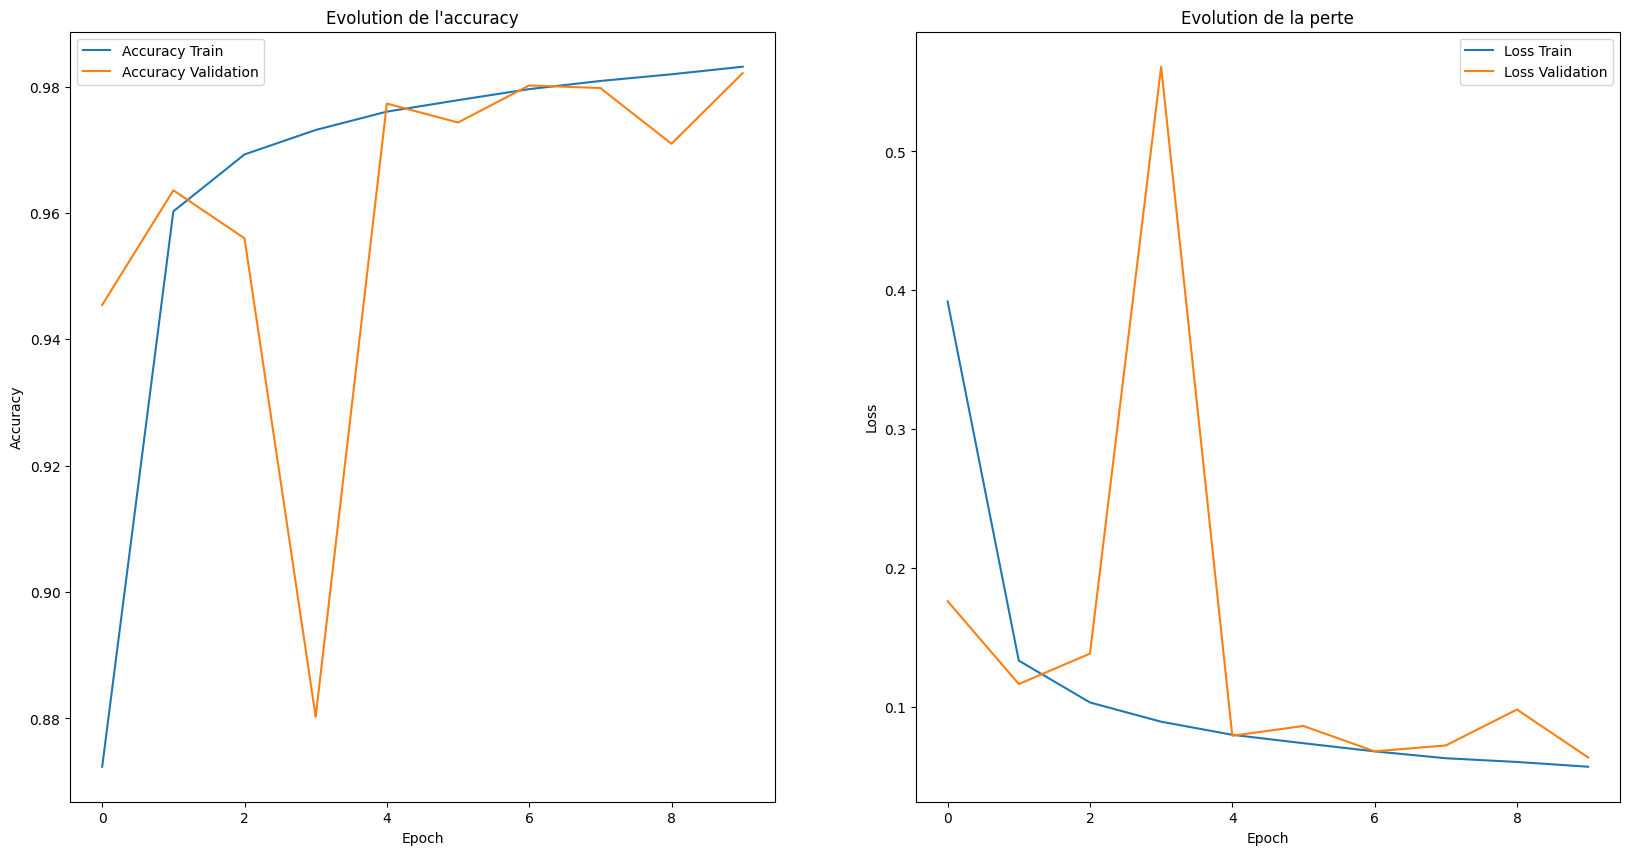

Acccuracy :  0.9831523776054383
Loss :  0.05660871341824532
Accuracy Validation :  0.9821428537368775
Loss Validation :  0.06328528895974159


In [11]:
# Entrainement - Cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
loss = []
val_accuracies = []
val_loss = []
i = 1

for train_index, val_index in kf.split(x_train, y_train):
    X, x_val = x_train[train_index], x_train[val_index]
    y, y_val = y_train[train_index], y_train[val_index]

    print(f"Fold {i}")
    i += 1

    model = build_model()
    historique = model.fit(X, y, epochs=10, validation_data=(x_val, y_val), batch_size=128)

    accuracies.append(historique.history["accuracy"])
    val_accuracies.append(historique.history["val_accuracy"])
    loss.append(historique.history["loss"])
    val_loss.append(historique.history["val_loss"])

    clear_output(wait=True)

accuracies = np.array(accuracies)
loss = np.array(loss)
val_accuracies = np.array(val_accuracies)
val_loss = np.array(val_loss)

accuracies = np.mean(accuracies, axis=0)
loss = np.mean(loss, axis=0)
val_accuracies = np.mean(val_accuracies, axis=0)
val_loss = np.mean(val_loss, axis=0)

# Affichage accuracy - loss
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(accuracies, label='Accuracy Train')
axs[0].plot(val_accuracies, label='Accuracy Validation')
axs[0].set_title(f"Evolution de l'accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(loss, label='Loss Train')
axs[1].plot(val_loss, label='Loss Validation')
axs[1].set_title(f"Evolution de la perte")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
plt.show()

print('Acccuracy : ', accuracies[-1])
print('Loss : ', loss[-1])
print('Accuracy Validation : ', val_accuracies[-1])
print('Loss Validation : ', val_loss[-1])

In [20]:
# Sauvegarde

model.save('mon_modele.h5')
from google.colab import files
files.download('mon_modele.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Charger
from tensorflow.keras.models import load_model

model = load_model("model/mon_modele.h5")

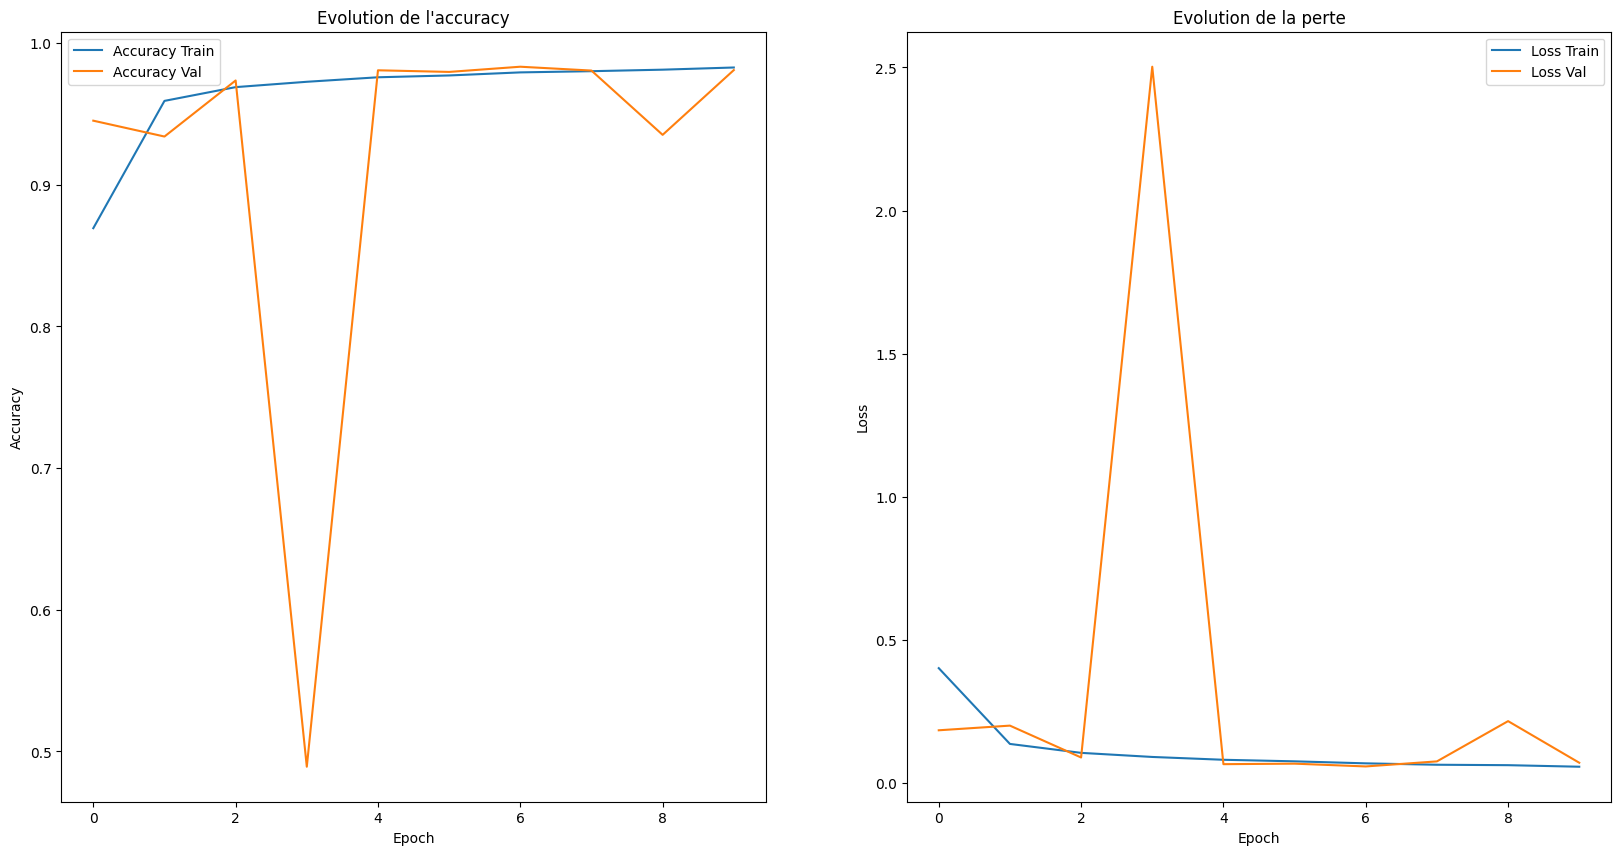

In [12]:
Graphes.accuracy_loss_graphe(historique)

Maintenant, voici les résultats sur les tests de base

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



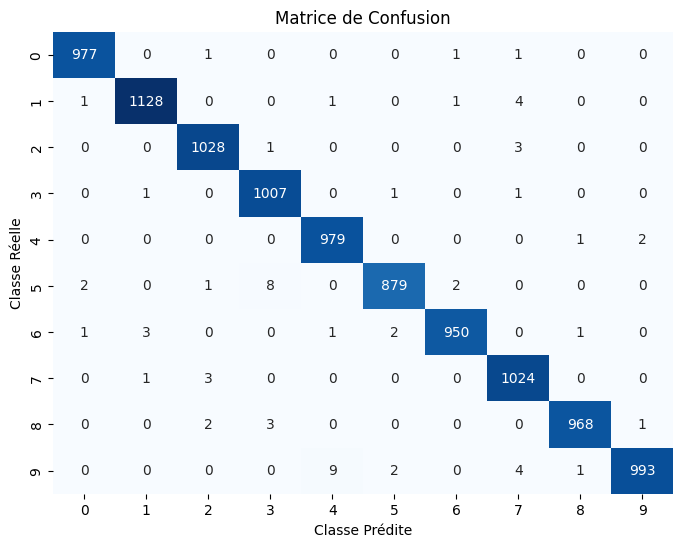

In [13]:
# Stats et matrice de confusion

predictions = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"]))

confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_1.png", format="png")
plt.show()


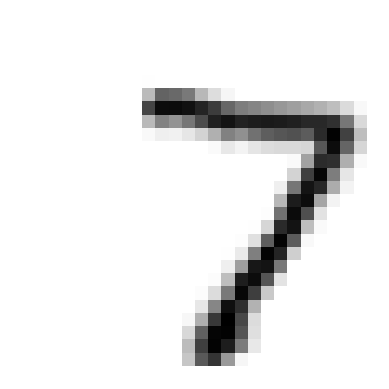

In [14]:
# generation_propre

new_images_propre, new_images_propre_label = generation_propre(x_test, y_test, nb=10000, seed=2)
new_images_propre, new_images_propre_label = new_images_propre[10000:], new_images_propre_label[10000:]

Et voici les résultats sur les 10 000 images de tests après avoir été modifiées par _generation_propre_ (style 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.97      0.99      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



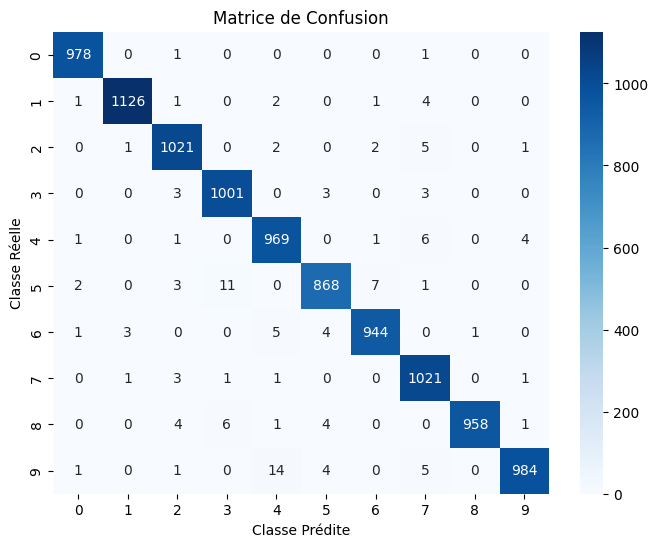

In [15]:
# Stats et matrice de confusion sur données générées (generation_propre)


# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images_propre), axis=1)

print(classification_report(new_images_propre_label, new_pred))

confusion = confusion_matrix(new_images_propre_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



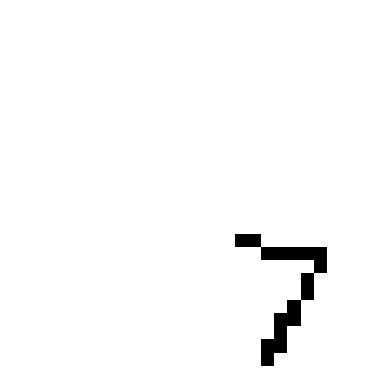

In [ ]:
# generation_2
new_images, new_images_label = generation_imparfaite(x_test, y_test, seed=2)
new_images, new_images_label = new_images[10000:], new_images_label[10000:]

3e tests, toujours les 10 000 images du jeu de tests mais cette fois, en etant modifiées pas generation_imparfaite (style 2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.96      0.97      0.97      1032
           3       0.91      0.94      0.93      1010
           4       0.94      0.96      0.95       982
           5       0.97      0.94      0.95       892
           6       0.99      0.95      0.97       958
           7       0.88      0.99      0.93      1028
           8       0.99      0.87      0.93       974
           9       0.95      0.91      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



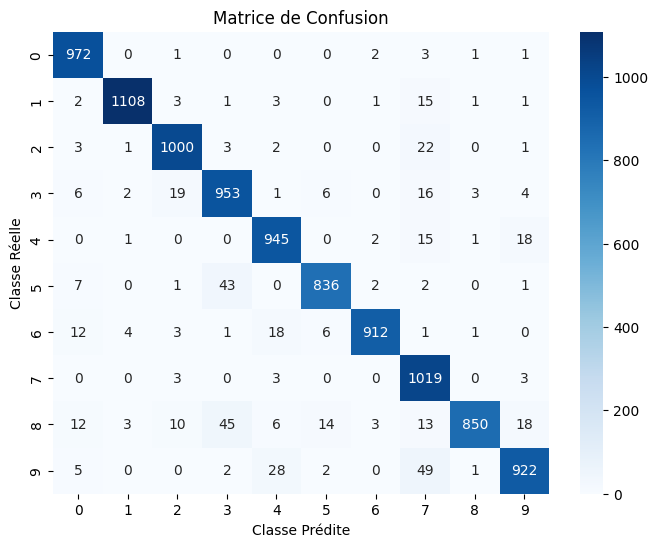

In [17]:
# Stats et matrice de confusion sur données générées (generation_2)

# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



In [ ]:
# Combinaison de toutes les données de tests

x_test_global = np.concatenate((x_test, new_images, new_images_propre))
y_test_global = np.concatenate((y_test, new_images_label, new_images_propre_label))

Enfin, la moyenne des 3 tests précédent (30 000 images au total)

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0     0.9809    0.9956    0.9882      2940
           1     0.9938    0.9874    0.9906      3405
           2     0.9794    0.9848    0.9821      3096
           3     0.9595    0.9772    0.9683      3030
           4     0.9676    0.9820    0.9747      2946
           5     0.9818    0.9652    0.9734      2676
           6     0.9912    0.9763    0.9837      2874
           7     0.9463    0.9935    0.9693      3084
           8     0.9957    0.9500    0.9723      2922
           9     0.9807    0.9577    0.9691      3027

    accuracy                         0.9773     30000
   macro avg     0.9777    0.9770    0.9772     30000
weighted avg     0.9777    0.9773    0.9773     30000



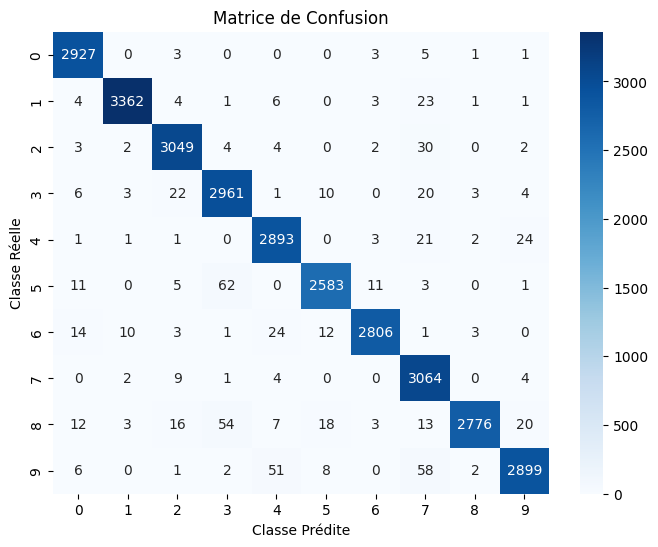

In [19]:
# Stats et matrice de confusion sur TOUTES données

new_pred = np.argmax(model.predict(x_test_global), axis=1)

print(classification_report(y_test_global, new_pred, digits=4))

confusion = confusion_matrix(y_test_global, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_final.png", format="png")
plt.show()

